In [22]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# set global path
PATH = '/home/canliu/ENL_NetDissect/patches_VAE/MIT_ImageRatings'
INDEXFILE = 'MIT_ImageRatings.csv'
IMAGEPATH = 'All_other_MIT_images'

In [24]:
# get natrualness rating
image_to_score = load_index(file_path = PATH, index_path = INDEXFILE)
print("number of images: {}".format(len(list(image_to_score.keys()))))

number of images: 1105


In [25]:
# clean the list (some images do not exist)
sorted_image_to_score = []
for image in image_to_score:
    image_path = os.path.join(PATH, IMAGEPATH, image)
    if os.path.exists(image_path):
        sorted_image_to_score.append((image_to_score[image], image))
sorted_image_to_score.sort()

In [26]:
print("number of existing images: {}".format(len(sorted_image_to_score)))
del(image_to_score)

number of existing images: 1030


offset: 14


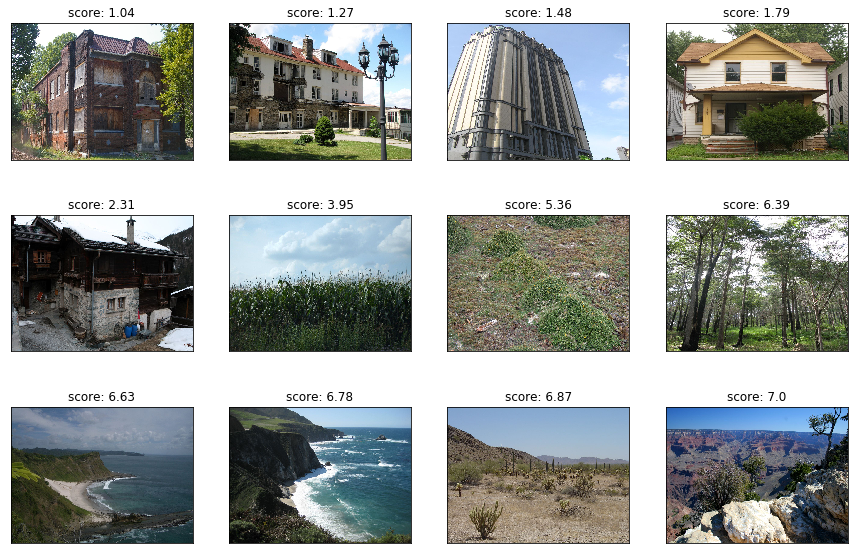

In [27]:
# look at some of the images
import random
offset = random.randint(0, 20)
print("offset: {}".format(offset))
fig = plt.figure(figsize = (15, 10))
for i, rank in enumerate(range(0, 1030, 90)):
    image = sorted_image_to_score[rank + offset]
    image_path = os.path.join(PATH, IMAGEPATH, image[1])
    fig.add_subplot(3, 4, i + 1, yticks = [], xticks = [], title = "score: {}".format(image[0]))
    plt.imshow(plt.imread(image_path))
plt.show()

- heuristic thresholds:
    - smaller than 2: urban
    - 2 ~ 4: neutral
    - greater than 4: nature

In [28]:
# count number
count_nature, count_neutral, count_urban = 0, 0, 0
for pair in sorted_image_to_score:
    if pair[0] <= 2:
        count_urban += 1
    elif pair[0] >= 4:
        count_nature += 1
    else:
        count_neutral += 1
print("number of urban: {}, neutral: {}, nature: {}".format(count_urban, count_neutral, count_nature))

number of urban: 333, neutral: 132, nature: 565


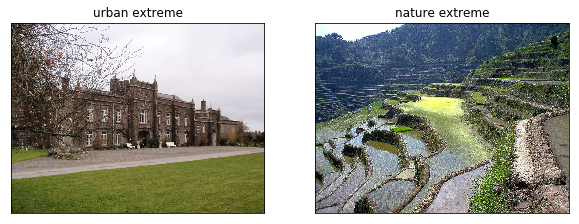

In [29]:
# visualize extreme images
fig = plt.figure(figsize = (10, 10))
urban_extreme = sorted_image_to_score[332]
urban_extreme_path = os.path.join(PATH, IMAGEPATH, urban_extreme[1])
fig.add_subplot(1, 2, 1, yticks = [], xticks = [], title = "urban extreme")
plt.imshow(plt.imread(urban_extreme_path))
nature_extreme = sorted_image_to_score[-565]
nature_extreme_path = os.path.join(PATH, IMAGEPATH, nature_extreme[1])
fig.add_subplot(1, 2, 2, yticks = [], xticks = [], title = "nature extreme")
plt.imshow(plt.imread(nature_extreme_path))

In [9]:
# crop image example
STRIDE = 60
PSIZE = 64
example_patches = gen_patches(urban_extreme[1], file_path=PATH, image_path=IMAGEPATH, stride=STRIDE, psize=PSIZE)
print("number of patches: {}".format(example_patches.shape[0] * example_patches.shape[1]))

shape of patches: (19, 14, 64, 64, 3)
number of patches: 266


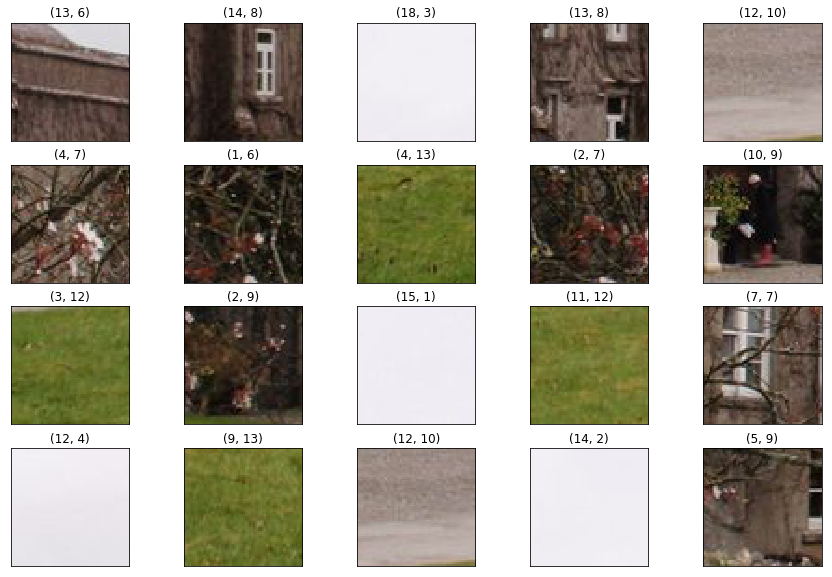

In [10]:
# visualize
fig = plt.figure(figsize = (15, 10))
for i in range(20):
    row = random.randint(0, 18)
    col = random.randint(0, 13)
    fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[], title="({}, {})".format(row, col))
    plt.imshow(example_patches[row][col])
plt.show()

In [11]:
import glob
import sys
from collections import OrderedDict
import caffe
from DeepImageSynthesis import *

In [12]:
base_dir = os.getcwd()
sys.path.append(base_dir)

In [13]:
VGGweights = os.path.join(base_dir, 'Models/vgg_normalised.caffemodel')
VGGmodel = os.path.join(base_dir, 'Models/VGG_ave_pool_deploy.prototxt')

In [14]:
image_mean = np.array([0.4775267, 0.49077275, 0.463214])

In [15]:
# set gpu
gpu = 0
caffe.set_mode_gpu()
caffe.set_device(gpu)

# set cpu
# caffe.set_mode_cpu()

In [17]:
def load_net(net_model, net_weights, batchSize, size, mean):
    with open(net_model,'r+') as f:
        data = f.readlines() 
        data[2] = "input_dim: %i\n" %(batchSize)
        data[4] = "input_dim: %i\n" %(size[0])
        data[5] = "input_dim: %i\n" %(size[1])

    with open(net_model,'r+') as f:
        f.writelines(data)
    
    net_mean =  np.tile(mean[:,None,None],(1,) + tuple(size.astype(int)))
    
    net = caffe.Classifier( 
    net_model, net_weights,
    mean = net_mean,
    channel_swap=(2,1,0),
    input_scale=255,)
    
    return net

In [32]:
# save file name image:row:col:layer
import time
def get_gram(image, net):
    gram_start_time = time.time()
    grams = {}
    print("image: {}".format(image))
    base_dir = os.getcwd()
    gram_path = os.path.join(base_dir, "grams")
    if image[0] <= 2:
        gram_path = os.path.join(gram_path, 'urban')
    elif image[0] >= 4:
        gram_path = os.path.join(gram_path, 'nature')
    else:
        gram_path = os.path.join(gram_path, 'neutral')
        
    patches = gen_patches(image[1], file_path=PATH, image_path=IMAGEPATH, stride=STRIDE, psize=PSIZE)
    
    image_name = image[1].split('.')[0]
    num_rows, num_cols = patches.shape[0], patches.shape[1]
    
    for row in range(num_rows):
        for col in range(num_cols):
            patch = patches[row][col]
            im_size = 64.

            # unwrap load_image
            if isinstance(im_size,float):
                im_scale = np.sqrt(im_size**2 /np.prod(np.asarray(patch.shape[:2])))
                im_size = im_scale * np.asarray(patch.shape[:2])

            img_pp = net.transformer.preprocess('data', patch)[None,:]

            im_size = np.asarray(img_pp.shape[-2:])
            constraints = OrderedDict()
            net.forward(data = img_pp)

            for l,layer in enumerate(tex_layers):
                constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                        [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                         'weight': tex_weights[l]}])
            for l, layer in enumerate(tex_layers):
                matrix_name = ':'.join([str(row), str(col), layer])
                grams[matrix_name] = constraints[layer].parameter_lists[0]['target_gram_matrix']
                #np.save(os.path.join(gram_path, matrix_name), constraints[layer])
    np.savez_compressed(os.path.join(gram_path, image_name), **grams)
    gram_end_time = time.time()
    print("takes time: {}".format(gram_end_time - gram_start_time))

In [33]:
# layers to look at
# each image takes ~ 16 seconds
tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
tex_weights = [1e9,1e9,1e9,1e9,1e9]

# these parameters are set for image synthesis
maxiter = 100
m = 20

# load network
net = load_net(VGGmodel, VGGweights, batchSize = 1, size = np.array([64, 64]), mean = image_mean)

for image in sorted_image_to_score[:200]:
    get_gram(image, net)

image: (1.0, '2915825346_8ab54dee48_o.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 20.817662954330444
image: (1.0, '4477947944_a4808e0f07_o.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 22.06439208984375
image: (1.0, '9232732578_68f25ea0fe_o.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 21.888923406600952
image: (1.0, 'labelme_bwccfvgaubpcgkv.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 21.211858987808228
image: (1.0, 'labelme_calrsncqddcdefi.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 20.332532167434692
image: (1.0, 'labelme_cayopaonuntzxio.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 20.043323516845703
image: (1.0, 'labelme_cfdiefghsjwrogz.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 20.162590503692627
image: (1.0, 'labelme_erixdzoszhkmtvc.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 19.769505977630615
image: (1.0, 'labelme_gtkravuhwhdsfej.jpg')
shape of patches: (19, 14, 64, 64, 3)
takes time: 19.

OSError: [Errno 122] Disk quota exceeded

In [73]:
# gram matrix of each layer
for layer in tex_layers:
    gram = constraints[layer].parameter_lists[0]['target_gram_matrix']
    print("layer: {}, gram shape: {}".format(layer, gram.shape))

layer: pool4, gram shape: (512, 512)
layer: pool3, gram shape: (256, 256)
layer: pool2, gram shape: (128, 128)
layer: pool1, gram shape: (64, 64)
layer: conv1_1, gram shape: (64, 64)


- Generate Gram Matrix Temporary Notes
    - 0 ~ 200